In [1]:
from fastai.vision.all import *
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
train_df = pd.read_csv('./Dataset/fairface_label_train.csv').drop(columns=['service_test'])
val_df = pd.read_csv('./Dataset/fairface_label_val.csv').drop(columns=['service_test']) 

In [3]:
age_labels = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', 'more than 70']
gender_labels = ['Male', 'Female']
race_labels = ['White', 'Black', 'East Asian', 'Southeast Asian', 'Indian', 'Middle Eastern', 'Latino_Hispanic']

In [4]:
fairface_block = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),   # Image and MultiCategory for multi-label classification
    get_x=ColReader('file', pref='./Dataset/'),                   # Load images from the 'file' column
    get_y=ColReader(['age', 'gender', 'race']),  # Get the age, gender, race labels
    splitter=RandomSplitter(seed=42),           # Split the data randomly
    item_tfms=Resize(224),                      # Resize all images to 224x224
    batch_tfms=aug_transforms(mult=1.0, max_rotate=20.0, max_zoom=1.2, max_warp=0.2, p_affine=0.75)  # Augmentations
)

dls = fairface_block.dataloaders(train_df, bs=64)

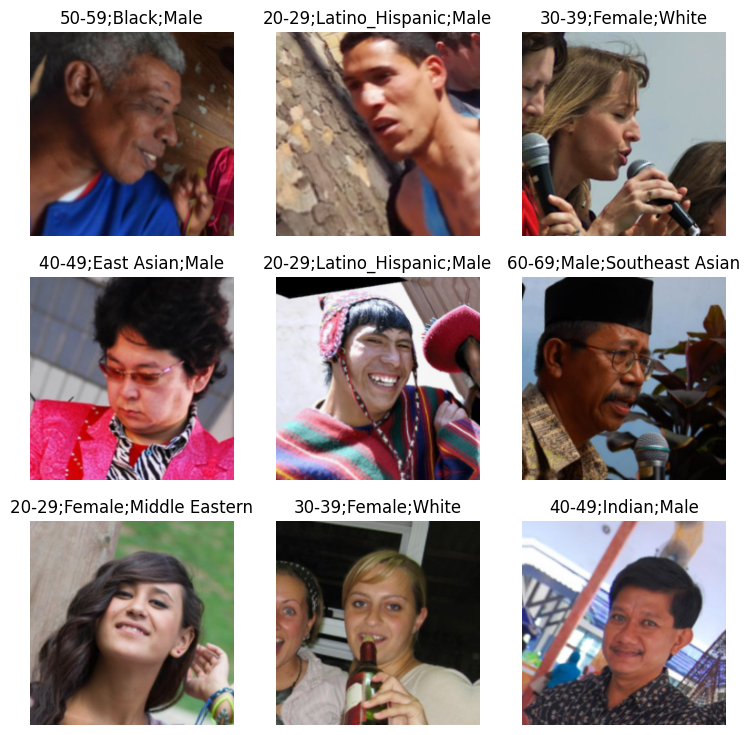

In [5]:
dls.show_batch()

In [6]:
learn = vision_learner(dls, resnet34, metrics=[partial(accuracy_multi, thresh=0.5)])  

In [7]:
learn.fine_tune(10, base_lr=1e-3, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.474257,0.354308,0.864701,05:30
1,0.315537,0.291934,0.878770,05:32
2,0.289936,0.270752,0.886096,05:32


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.246966,0.234539,0.898560,07:31
1,0.224877,0.217601,0.905157,07:29
2,0.215387,0.209474,0.907447,07:30
3,0.200426,0.199183,0.912055,07:36
4,0.191825,0.194147,0.913980,07:44
5,0.179380,0.192503,0.915187,07:44
6,0.174982,0.188673,0.916436,07:42
7,0.163120,0.188160,0.917230,07:33
8,0.157249,0.188789,0.917349,07:32
9,0.156506,0.188582,0.917522,07:32


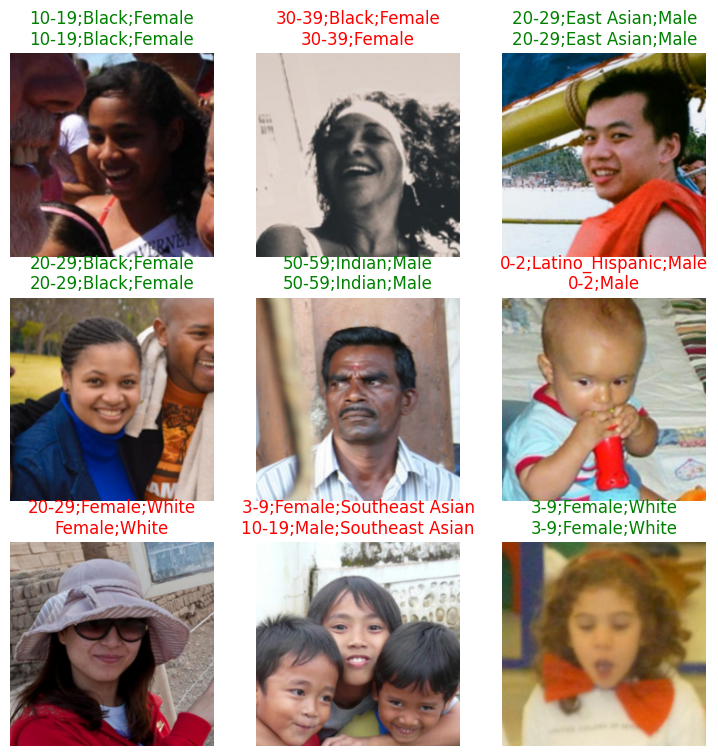

In [8]:
learn.show_results()

In [19]:
img = PILImage.create('./Dataset/val/258.jpg')
pred, pred_idx, probs = learn.predict(img)

age_probs = probs[:len(age_labels)]
gender_probs = probs[len(age_labels):len(age_labels) + len(gender_labels)]
race_probs = probs[len(age_labels) + len(gender_labels):]

def print_probabilities(label_type, labels, probabilities):
    print(f"\n{label_type} Category Probabilities:")
    for label, prob in zip(labels, probabilities):
        print(f'{label}: {prob:.4f}')

print_probabilities("Age", age_labels, age_probs)
print_probabilities("Gender", gender_labels, gender_probs)
print_probabilities("Race", race_labels, race_probs)


Age Category Probabilities:
0-2: 0.9382
3-9: 0.0003
10-19: 0.0008
20-29: 0.0324
30-39: 0.0043
40-49: 0.0036
50-59: 0.0014
60-69: 0.0007
more than 70: 0.0048

Gender Category Probabilities:
Male: 0.0004
Female: 0.9532

Race Category Probabilities:
White: 0.9872
Black: 0.0125
East Asian: 0.0468
Southeast Asian: 0.0004
Indian: 0.0018
Middle Eastern: 0.0011
Latino_Hispanic: 0.0004


In [10]:
learn.export('../models/fairface_v2.pkl')

In [11]:
torch.save(learn.model.state_dict(), '../models/fairface_v2.pth')